In [33]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import xgboost as xgb
import pandas as pd

In [34]:
label_encoder = LabelEncoder()

df = pd.read_csv('Processed Data.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 92 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   rowid               9564 non-null   int64  
 1   koi_disposition     9564 non-null   object 
 2   koi_score           9564 non-null   float64
 3   koi_fpflag_nt       9564 non-null   int64  
 4   koi_fpflag_ss       9564 non-null   int64  
 5   koi_fpflag_co       9564 non-null   int64  
 6   koi_fpflag_ec       9564 non-null   int64  
 7   koi_period          9564 non-null   float64
 8   koi_time0bk         9564 non-null   float64
 9   koi_time0           9564 non-null   float64
 10  koi_impact          9564 non-null   float64
 11  koi_impact_err1     9564 non-null   float64
 12  koi_impact_err2     9564 non-null   float64
 13  koi_duration        9564 non-null   float64
 14  koi_duration_err1   9564 non-null   float64
 15  koi_duration_err2   9564 non-null   float64
 16  koi_de

In [35]:
df['koi_disposition_encoded'] = label_encoder.fit_transform(df['koi_disposition'])

print("Original classes:", df['koi_disposition'].unique())
print("Encoded classes:", df['koi_disposition_encoded'].unique())
print("Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

Original classes: ['CONFIRMED' 'CANDIDATE' 'FALSE POSITIVE']
Encoded classes: [1 0 2]
Mapping: {'CANDIDATE': np.int64(0), 'CONFIRMED': np.int64(1), 'FALSE POSITIVE': np.int64(2)}


In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['koi_disposition', 'koi_disposition_encoded'], axis=1), 
    df['koi_disposition_encoded'], 
    test_size=0.2, 
    random_state=42
)
clf = xgb.XGBClassifier(tree_method="hist", early_stopping_rounds=2, n_estimators=100)

clf.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)]
)

[0]	validation_0-mlogloss:0.78257
[1]	validation_0-mlogloss:0.59709
[2]	validation_0-mlogloss:0.47595
[3]	validation_0-mlogloss:0.39486
[4]	validation_0-mlogloss:0.33342
[5]	validation_0-mlogloss:0.29016
[6]	validation_0-mlogloss:0.25791
[7]	validation_0-mlogloss:0.23447
[8]	validation_0-mlogloss:0.21606
[9]	validation_0-mlogloss:0.20241
[10]	validation_0-mlogloss:0.19157
[11]	validation_0-mlogloss:0.18349
[12]	validation_0-mlogloss:0.17781
[13]	validation_0-mlogloss:0.17376
[14]	validation_0-mlogloss:0.16946
[15]	validation_0-mlogloss:0.16732
[16]	validation_0-mlogloss:0.16456
[17]	validation_0-mlogloss:0.16118
[18]	validation_0-mlogloss:0.15966
[19]	validation_0-mlogloss:0.15986
[20]	validation_0-mlogloss:0.15877
[21]	validation_0-mlogloss:0.15685
[22]	validation_0-mlogloss:0.15605
[23]	validation_0-mlogloss:0.15555
[24]	validation_0-mlogloss:0.15514
[25]	validation_0-mlogloss:0.15596


,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,2
,enable_categorical,False
,eval_metric,None


Accuracy: 0.9462

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.86      0.87       405
           1       0.91      0.93      0.92       569
           2       0.99      0.99      0.99       939

    accuracy                           0.95      1913
   macro avg       0.93      0.93      0.93      1913
weighted avg       0.95      0.95      0.95      1913



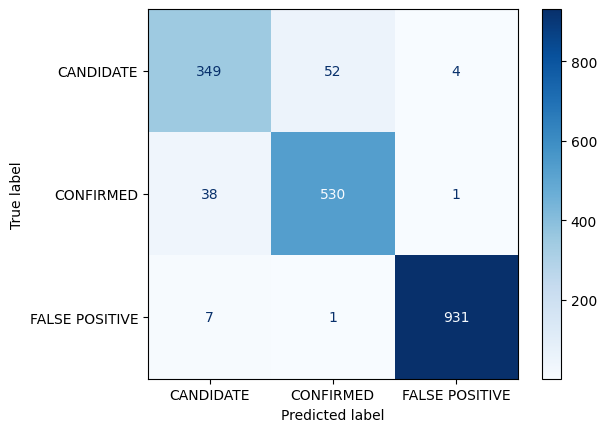

In [37]:
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')
plt.show()

# Convert numeric predictions back to original labels for better interpretability
y_pred_labels = label_encoder.inverse_transform(y_pred.astype(int))
y_test_labels = label_encoder.inverse_transform(y_test.astype(int))


### HYPERMPARAMETER OPTIMIZATION HESAABI

In [38]:
from scipy.stats import uniform, randint

parameter_grid = {
    'n_estimators': randint(100, 1000),  # Ağaç sayısı
    'max_depth': randint(3, 10),        # Maksimum ağaç derinliği
    'learning_rate': uniform(0.01, 0.3), # Öğrenme oranı
    'subsample': uniform(0.6, 0.4),     # Örnekleme oranı
    'colsample_bytree': uniform(0.6, 0.4), # Özellik örnekleme oranı
    'gamma': uniform(0, 0.5),           # Minimum kayıp azalması
    'min_child_weight': randint(1, 10), # Minimum çocuk ağırlığı
    'reg_alpha': uniform(0, 1),         # L1 düzenlileştirme (Lasso)
    'reg_lambda': uniform(0, 1)         # L2 düzenlileştirme (Ridge)
}

grid_search = RandomizedSearchCV(
    clf,
    param_distributions=parameter_grid,
    n_iter=10,
    scoring="accuracy",
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

grid_search.fit(X_train, y_train, eval_set=[(X_test, y_test)])
print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[0]	validation_0-mlogloss:0.86838
[1]	validation_0-mlogloss:0.71396
[2]	validation_0-mlogloss:0.59161
[3]	validation_0-mlogloss:0.50442
[4]	validation_0-mlogloss:0.43686
[5]	validation_0-mlogloss:0.38282
[6]	validation_0-mlogloss:0.34223
[7]	validation_0-mlogloss:0.30857
[8]	validation_0-mlogloss:0.28350
[9]	validation_0-mlogloss:0.26218
[10]	validation_0-mlogloss:0.24635
[11]	validation_0-mlogloss:0.22998
[12]	validation_0-mlogloss:0.21496
[13]	validation_0-mlogloss:0.20364
[14]	validation_0-mlogloss:0.19544
[15]	validation_0-mlogloss:0.18828
[16]	validation_0-mlogloss:0.18277
[17]	validation_0-mlogloss:0.17828
[18]	validation_0-mlogloss:0.17496
[19]	validation_0-mlogloss:0.17286
[20]	validation_0-mlogloss:0.17002
[21]	validation_0-mlogloss:0.16789
[22]	validation_0-mlogloss:0.16681
[23]	validation_0-mlogloss:0.16543
[24]	validation_0-mlogloss:0.16561
[25]	validation_0-mlogloss:0.16476
[26]	validation_0-mlogloss:0.16426
[0]	

In [39]:
xgb_model = xgb.XGBClassifier(**grid_search.best_params_)

xgb_model.fit(X_train, y_train)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,np.float64(0.9895022075365837)
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


Accuracy: 0.9441

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.84      0.87       405
           1       0.90      0.93      0.92       569
           2       0.99      0.99      0.99       939

    accuracy                           0.94      1913
   macro avg       0.93      0.92      0.93      1913
weighted avg       0.94      0.94      0.94      1913



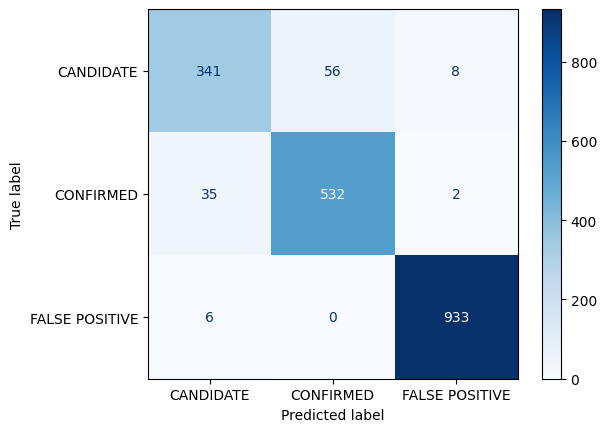

In [40]:
y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')
plt.show()

# Convert numeric predictions back to original labels for better interpretability
y_pred_labels = label_encoder.inverse_transform(y_pred.astype(int))
y_test_labels = label_encoder.inverse_transform(y_test.astype(int))
